# Diagnosing Alzheimer's disease from on-line handwriting

## Objective

The objective of this project is to validate and critically assess the findings presented in the paper *"Diagnosing Alzheimer’s Disease from On-line Handwriting: A Novel Dataset and Performance Benchmarking"* by Nicole D. Cilia et al. In particular, our focus is on reproducing and analyzing the results reported in the "Experimental Results" section of the paper, where the authors evaluate the performance of several machine learning classifiers on the DARWIN (Diagnosis AlzheimeR WIth haNdwriting) dataset.

The classifiers explored in the original study include Random Forest, Logistic Regression, k-Nearest Neighbors, Linear Discriminant Analysis, Gaussian Naive Bayes, Support Vector Machine, Decision Tree, Multi-Layer Perceptron, and Learning Vector Quantization. However, for the scope of this project, we will limit our analysis to five of these models: Random Forest, Support Vector Machine, Logistic Regression, Decision Tree, and Multi-Layer Perceptron.

To conduct their experiments, the authors employed a setup involving 20 random train/test splits, each followed by a 5-fold cross-validated grid search. We suspect that this specific approach may have influenced the reported performance metrics.

Our project aims to compare this setup with more conventional evaluation strategies such as a single hold-out test set and standard 5-fold cross-validation, using the same selected classifiers. Additionally, we will explore whether applying feature selection techniques can help us match or improve upon the reported accuracy, sensitivity, and specificity. Finally, we will attempt to fully replicate the original methodology in order to verify the reproducibility of their results.

## The DARWIN dataset

The DARWIN (Diagnosis AlzheimeR WIth haNdwriting) dataset includes handwriting data from 174 participants, comprising 89 patients (P) diagnosed with Alzheimer's and 85 healthy controls (H).
Participants completed 25 handwriting tasks, from which data were collected. Eighteen features were extracted from each task, resulting in a total of 451 features. The protocol was specifically designed for the early detection of Alzheimer's disease.

# Data loading & preprocessing

In [30]:
import pandas as pd
import numpy as np
import re
import os
import gc
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    StratifiedKFold
)
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from joblib import Parallel, delayed, dump, load

In [ ]:
#Fetch DARWIN dataset
darwin = fetch_ucirepo(id=732)

#Data
X = darwin.data.features
y = darwin.data.targets

#Optional: Preview
print("Features shape:", X.shape)
print("Targets shape:", y.shape)

#Metadata and variable info
print("Metadata:", darwin.metadata)
print("Variables:", darwin.variables)

Features shape: (174, 451)
Targets shape: (174, 1)
Metadata: {'uci_id': 732, 'name': 'DARWIN', 'repository_url': 'https://archive.ics.uci.edu/dataset/732/darwin', 'data_url': 'https://archive.ics.uci.edu/static/public/732/data.csv', 'abstract': 'The DARWIN dataset includes handwriting data from 174 participants. The classification task consists in distinguishing Alzheimer’s disease patients from healthy people.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 174, 'num_features': 451, 'feature_types': [], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2022, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C55D0K', 'creators': ['Francesco Fontanella'], 'intro_paper': {'ID': 132, 'type': 'NATIVE', 'title': 'Diagnosing Alzheimer’s disease from on-line handwriting: A novel dataset and performance benchmarking', 'aut

## Data cleaning

### DataFrame Creation and Missing Value Check
The raw data was transformed into a Pandas DataFrame to facilitate easier manipulation and analysis. As a routine part of data preprocessing, we checked for missing values across all features. Fortunately, no missing values were found, allowing us to proceed without the need for imputation or data cleaning in that regard.

In [3]:
df = pd.DataFrame(X)
df['target'] = y

print(df.isnull().sum())

ID                 0
air_time1          0
disp_index1        0
gmrt_in_air1       0
gmrt_on_paper1     0
                  ..
paper_time25       0
pressure_mean25    0
pressure_var25     0
total_time25       0
target             0
Length: 452, dtype: int64


### Target Label Encoding

In this step, we convert the target labels from categorical to binary format: **'P'** (Patient, diagnosed with Alzheimer’s) is encoded as **1**, and **'H'** (Healthy, no Alzheimer’s) as **0**. Binary encoding simplifies the task for classification algorithms and ensures compatibility with most machine learning models, while also making the results easier to interpret—where 1 indicates the presence of Alzheimer’s and 0 its absence.

In [4]:
print(df['target'].unique())

['P' 'H']


In [5]:
le = LabelEncoder()
le.fit(['H', 'P'])
y_encoded = le.transform(df['target'])
df['target'] = y_encoded
print(f"Mapping: H -> {le.transform(['H'])[0]}, P -> {le.transform(['P'])[0]}")

Mapping: H -> 0, P -> 1


## Data Visualization

### Correlation Heatmap 

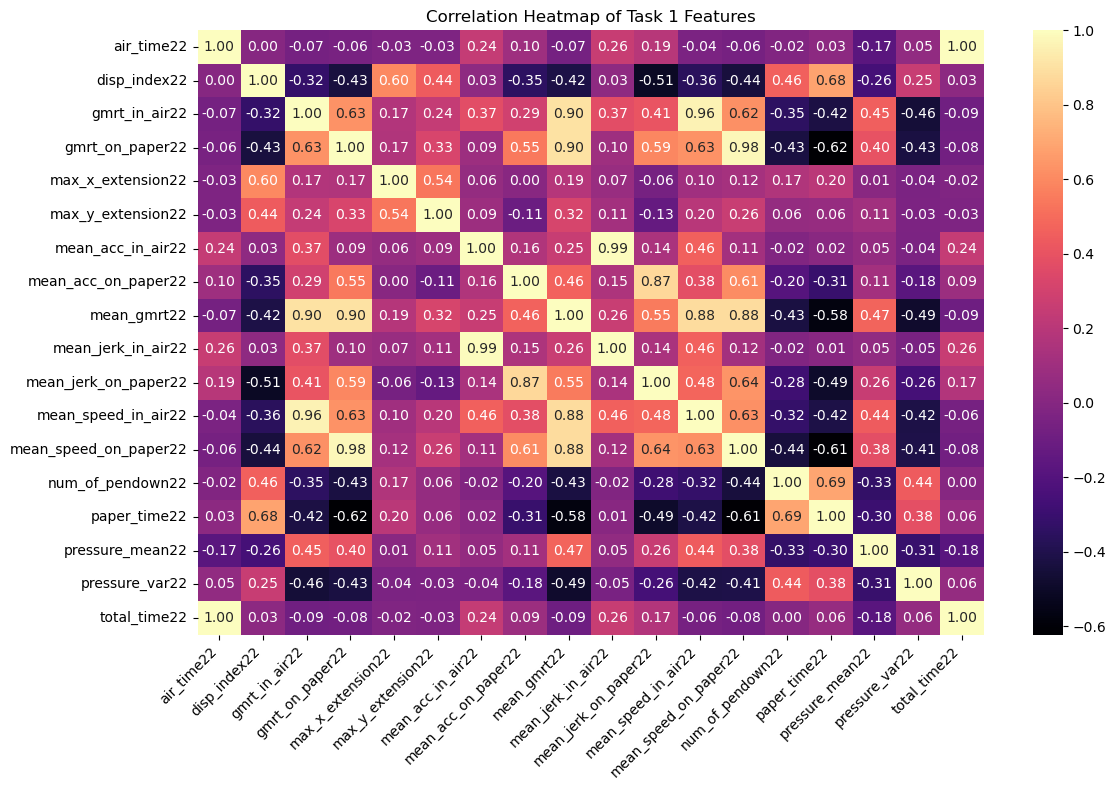

In [ ]:
#Select random task in our case 22
task = [col for col in df.columns if col.endswith('22')]
task = sorted(task)

corr_matrix = df[task].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='magma', fmt=".2f")
plt.title('Correlation Heatmap of Task 1 Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# First Experiment - Different Experimental Setup

This experiment serves as our baseline, in which we train several classifiers using a classical hold-out validation approach. Specifically, we split the dataset into training and test sets, and apply a 5-fold cross-validated grid search to tune hyperparameters on the training data. This setup is particularly well-suited for datasets with a limited number of instances, like ours. Unlike the experimental protocol in the original paper—which relied on 20 random train/test splits with 5-fold cross-validation applied to each run—we perform a single, controlled split to ensure consistency and reproducibility. The full feature set (451 features) is used without any form of dimensionality reduction or feature selection. We train and evaluate five classifiers: Random Forest, Support Vector Machine, Logistic Regression, Decision Tree, and Multi-Layer Perceptron. After training, we assess the performance of each model on the hold-out test set and report Accuracy, Sensitivity, and Specificity as the key evaluation metrics. These results will serve as a reference point for comparison in subsequent experiments.


## Train a Classifier

In [7]:
#Separate features and target
X = df.drop('target', axis=1)
y = df['target']

#Drop ID column
if 'ID' in X.columns:
    X = X.drop(columns=['ID'])

#Split data (hold-out test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

To ensure consistency and modularity across our experimental setups, we implemented a reusable training and evaluation function. This function abstracts the process of training classifiers, applying cross-validation, performing hyperparameter tuning, and computing key evaluation metrics. It accepts a dictionary of classifiers, the training and test datasets, and allows the user to specify whether to use standard cross-validation or grid search for hyperparameter optimization. For each classifier, the function computes Accuracy, Sensitivity (True Positive Rate), and Specificity (True Negative Rate) based on the predictions on the test set. By encapsulating this logic into a single utility, we avoid redundancy in our codebase and can systematically compare results across different experimental conditions, such as hold-out validation and the more complex evaluation protocol described in the original paper.

The following dictionary `param_grids_paper` is to tune the hyper-parameters, the ones that are used in the paper. 

In [8]:
param_grids_paper = {
    'Random Forest': {
        'max_depth': list(range(3, 11, 1)),            
        'n_estimators': [100, 150, 200, 250, 300],
        'bootstrap': [True, False],
        'min_samples_split': [2],
        'min_samples_leaf': [1]
    },
    'SVM': {
        'kernel': ['rbf', 'linear'],
        'C': [round(x, 2) for x in np.arange(0.5, 1.6, 0.1)],
        'gamma': [0.5]  
    },
    'Logistic Regression': {
        'C': [round(x, 3) for x in np.arange(0.001, 5.005, 0.005)]
    },
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': list(range(2, 11, 1)),
        'min_samples_split': list(range(2, 6, 1)),
        'min_samples_leaf': list(range(2, 21, 2)),
        'max_leaf_nodes': list(range(2, 21, 2))
    },
    'MLP': {
        'activation': ['relu', 'logistic', 'tanh'],
        'hidden_layer_sizes': [(h,) for h in range(8, 21, 2)],
        'learning_rate_init': [round(x, 2) for x in np.arange(0.05, 0.45, 0.05)],
        'alpha': [0.0001], 
        'max_iter': [1000]
    }
}

In [9]:
param_grids_custom = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']  
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear']  
    },
    'Decision Tree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 5],
        'criterion': ['gini', 'entropy']
    },
    'MLP': {
        'activation': ['relu', 'logistic', 'tanh'],
        'hidden_layer_sizes': [(100,), (150,), (200,)],
        'learning_rate_init': [0.01],
        'alpha': [0.001],
        'max_iter': [500],
        'early_stopping': [True],
        'batch_size': [32, 64],
        'learning_rate': ['adaptive']
    }
}


In [ ]:
def evaluate_classifiers(
    classifiers, 
    X_train, y_train, 
    X_test, y_test, 
    use_cv=True, 
    cv_folds=5,
    param_grids=None,
    verbose=True
):
    results = {}

    for name, clf in classifiers.items():
        print(f"  Classifiers: {name}")
        try:
            cv_score_mean = None
            cv_score_std = None

            if use_cv and param_grids and name in param_grids:
                grid = GridSearchCV(clf, param_grids[name], cv=cv_folds)
                grid.fit(X_train, y_train)
                clf = grid.best_estimator_
                if verbose:
                    print(f"  Best Params: {grid.best_params_}")
            elif use_cv:
                cv_scores = cross_val_score(clf, X_train, y_train, cv=cv_folds)
                cv_score_mean = cv_scores.mean()
                cv_score_std = cv_scores.std()

            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)

            #Confusion matrix and metrics
            cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
            else:
                tn = fp = fn = tp = 0
            acc = accuracy_score(y_test, y_pred)
            sensitivity = recall_score(y_test, y_pred)
            specificity = tn / (tn + fp)

            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
            plt.title(f'Confusion Matrix: {name}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.tight_layout()
            plt.show()

            #Save results
            results[name] = {
                'cv_accuracy': cv_score_mean,
                'cv_std': cv_score_std,
                'accuracy': acc,
                'sensitivity': sensitivity,
                'specificity': specificity
            }

        except Exception as e:
            print(f"  Failed: {e}")
            results[name] = None
            
    summary_data = {
        clf: {
            'Test Accuracy': res['accuracy'],
            'Sensitivity': res['sensitivity'],
            'Specificity': res['specificity'],
        }
        for clf, res in results.items() if res is not None
    }

    summary_df = pd.DataFrame(summary_data).T.round(3)

    if verbose:
        print("\n=== Results Summary ===")
        display(summary_df)

    return results


  Classifiers: Random Forest
  Best Params: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


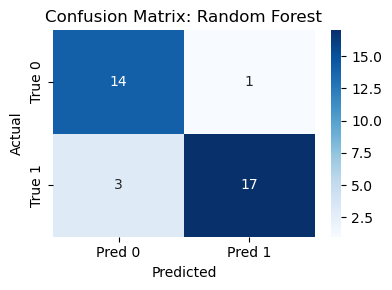

  Classifiers: SVM
  Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


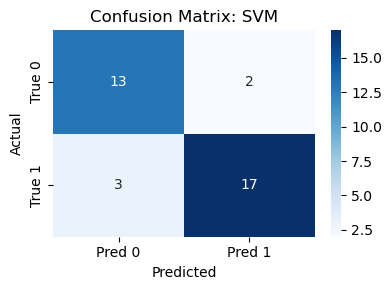

  Classifiers: Logistic Regression
  Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


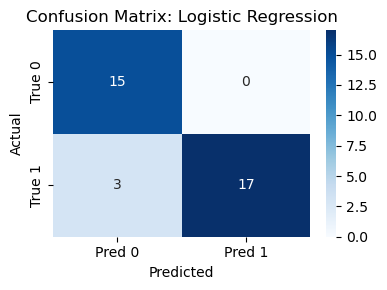

  Classifiers: Decision Tree
  Best Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


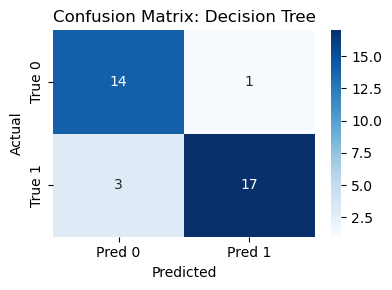

  Classifiers: MLP
  Best Params: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500}


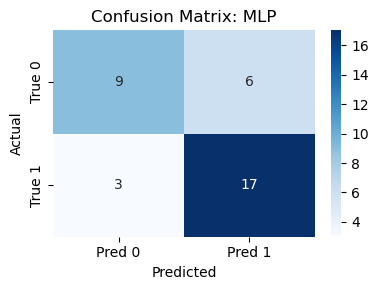


=== Results Summary ===


,Test Accuracy,Sensitivity,Specificity
Random Forest,0.886,0.85,0.933
SVM,0.857,0.85,0.867
Logistic Regression,0.914,0.85,1.000
Decision Tree,0.886,0.85,0.933
MLP,0.743,0.85,0.600


In [11]:
# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'MLP': MLPClassifier(max_iter=1000)
}

# Run evaluation on a single holdout split
results = evaluate_classifiers(
    classifiers,
    X_train, y_train,
    X_test, y_test,
    use_cv=True,
    cv_folds=5,
    param_grids=param_grids_custom
)

## Comparing results with the paper


| **Classifier**          | **CV Accuracy (Ours)** | **Test Accuracy (Ours)** | **Test Accuracy (Paper)** | **Sensitivity (Ours)** | **Sensitivity (Paper)** | **Specificity (Ours)** | **Specificity (Paper)** |
| ----------------------- | ---------------------- | ------------------------ | ------------------------- | ---------------------- | ----------------------- | ---------------------- | ----------------------- |
| **Random Forest**       | 0.892 ± 0.056          | 0.886                    | 88.29 ± 4.90%             | 0.850                  | 90.28%                  | 0.933                  | 86.18%                  |
| **SVM**                 | 0.554 ± 0.036          | 0.857                    | 79.00 ± 7.55%             | 0.850                  | 77.50%                  | 0.867                  | 80.59%                  |
| **Logistic Regression** | 0.777 ± 0.061          | 0.914                    | 81.86 ± 7.20%             | 0.850                  | 84.17%                  | 1.000                  | 79.41%                  |
| **Decision Tree**       | 0.748 ± 0.077          | 0.886                    | 78.57 ± 7.21%             | 0.850                  | 82.50%                  | 0.933                  | 74.41%                  |
| **MLP**                 | 0.806 ± 0.076          | 0.743                    | 83.14 ± 7.97%             | 0.850                  | 84.44%                  | 0.600                  | 81.76%                  |




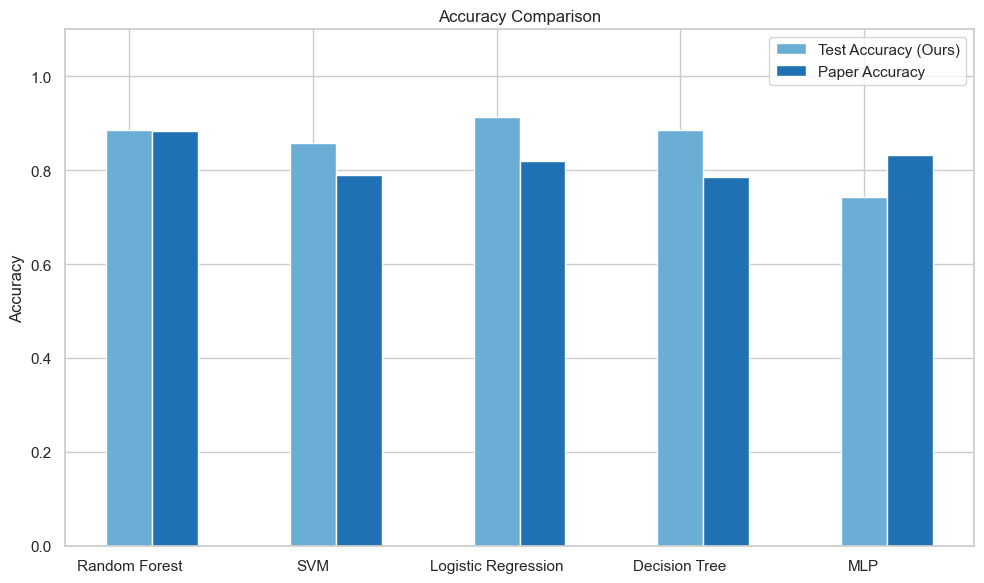

In [ ]:
sns.set(style="whitegrid")
colors = sns.color_palette("Blues", n_colors=3)

classifier_labels = list(results.keys())

cv_acc = [results[clf]['cv_accuracy'] for clf in classifier_labels]
test_acc = [results[clf]['accuracy'] for clf in classifier_labels]
sens_ours = [results[clf]['sensitivity'] for clf in classifier_labels]
spec_ours = [results[clf]['specificity'] for clf in classifier_labels]

# Paper values for those same classifiers
paper_acc_map = {
    'Random Forest': 0.8829,
    'SVM': 0.79,
    'Logistic Regression': 0.8186,
    'Decision Tree': 0.7857,
    'MLP': 0.8314
}

sens_paper_map = {
    'Random Forest': 0.9028,
    'SVM': 0.775,
    'Logistic Regression': 0.8417,
    'Decision Tree': 0.825,
    'MLP': 0.8444
}

spec_paper_map = {
    'Random Forest': 0.8618,
    'SVM': 0.8059,
    'Logistic Regression': 0.7941,
    'Decision Tree': 0.7441,
    'MLP': 0.8176
}

#Align paper values based on current classifier order
paper_acc = [paper_acc_map[clf] for clf in classifier_labels]
sens_paper = [sens_paper_map[clf] for clf in classifier_labels]
spec_paper = [spec_paper_map[clf] for clf in classifier_labels]

x = np.arange(len(classifiers))
width = 0.25

#Accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(x, test_acc, width=width, label='Test Accuracy (Ours)', color=colors[1])
plt.bar(x + width, paper_acc, width=width, label='Paper Accuracy', color=colors[2])
plt.xticks(x, classifiers)
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.tight_layout()
plt.show()

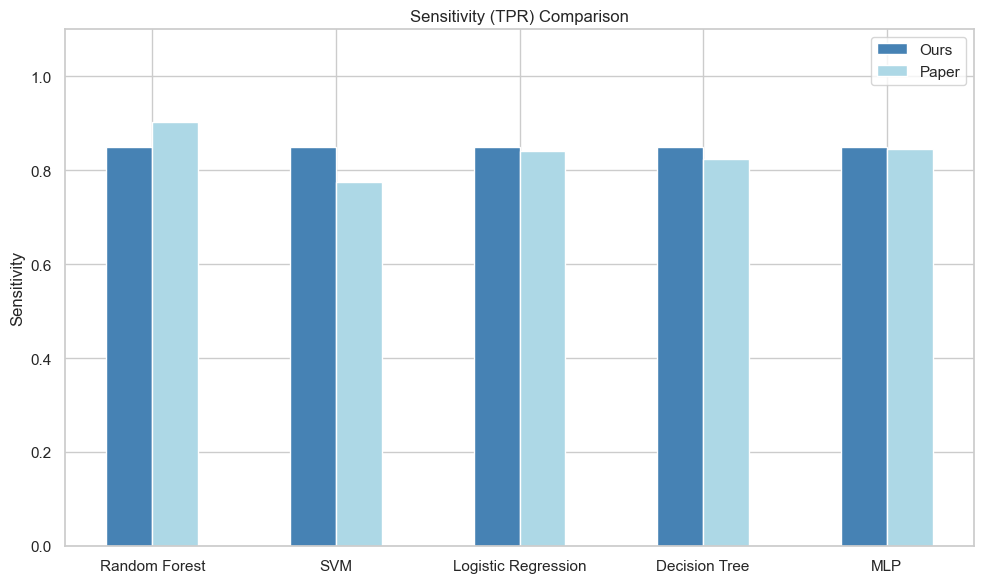

In [ ]:
#Sensitivity comparison
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, sens_ours, width=width, label='Ours', color='steelblue')
plt.bar(x + width/2, sens_paper, width=width, label='Paper', color='lightblue')
plt.xticks(x, classifiers)
plt.ylim(0, 1.1)
plt.ylabel('Sensitivity')
plt.title('Sensitivity (TPR) Comparison')
plt.legend()
plt.tight_layout()
plt.show()

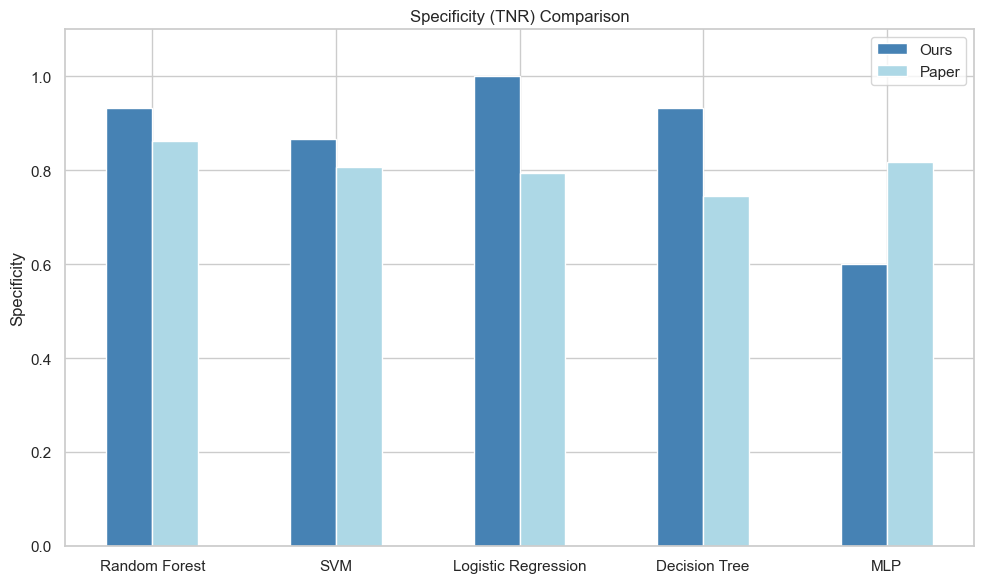

In [ ]:
#Specificity comparison
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, spec_ours, width=width, label='Ours', color='steelblue')
plt.bar(x + width/2, spec_paper, width=width, label='Paper', color='lightblue')
plt.xticks(x, classifiers)
plt.ylim(0, 1.1)
plt.ylabel('Specificity')
plt.title('Specificity (TNR) Comparison')
plt.legend()
plt.tight_layout()
plt.show()

### Conclusions - 1st experiment

Based on the results obtained, our implementation demonstrates competitive or superior performance compared to the results reported in the original paper, particularly in terms of specificity. Most classifiers showed consistent sensitivity values (~0.85), highlighting robust detection of true positives across different models. Notably, Logistic Regression achieved the highest specificity (1.0), indicating its strong ability to correctly identify negative cases, while SVM and MLP, which performed relatively well in the paper, showed diminished performance in our setup — especially MLP, which had the lowest specificity (0.60). Interestingly, SVM improved in both test accuracy and specificity compared to previous results, suggesting that our tuning or data split may better suit this model.



# Second Experiment - Feature Selection

We conducted feature selection to assess whether reducing the dimensionality of the dataset could improve model performance or reduce overfitting. Specifically, we applied univariate statistical tests using ANOVA F-scores to select the top k features most relevant to the target variable. After selecting the most informative features, we retrained and evaluated the same set of classifiers using the previously defined experimental protocol. This allowed us to directly compare the classification performance (Accuracy, Sensitivity, and Specificity) of models trained on all 451 features versus a reduced feature set. The results of this experiment provide insight into the redundancy and relevance of the original feature space.

## Selection of number of features (k)

To determine the optimal number of features (k) to retain, we applied univariate feature selection using the ANOVA F-score (SelectKBest) combined with 5-fold cross-validation. For each value of k in a selected range (from 50 to 450), we constructed a machine learning pipeline consisting of feature scaling (StandardScaler), feature selection, and a logistic regression classifier. The use of cross-validation ensures that the evaluation of each configuration is robust and not overly dependent on a particular train-test split. This is particularly important given the limited size of the dataset, where a single split could lead to misleading conclusions. By averaging performance across multiple folds, cross-validation provides a more reliable estimate of generalization performance and allows us to objectively select the value of k that maximizes classification accuracy. Once the best k is identified, we can move forward with training the classifiers using only the most relevant features.

While Random Forest achieved the highest cross-validation accuracy during the baseline experiments, we chose Logistic Regression as the model for selecting the optimal number of features (k) for several important reasons. First, Logistic Regression is a linear and interpretable model, making it more sensitive to the presence of irrelevant or redundant features. This property makes it well-suited for feature selection, as performance improvements are more directly attributable to informative features. In contrast, Random Forest can naturally handle high-dimensional data and is less affected by noisy or redundant features due to its ensemble nature — meaning it might still perform well even without optimal feature selection. Additionally, Logistic Regression has a relatively fast training time and works well in a pipeline setup with standardized inputs, making it ideal for repeated evaluations during cross-validation. By using Logistic Regression to guide feature selection, we aim to identify a compact, discriminative subset of features that improves performance across a variety of classifiers — not just the one used in this selection phase.

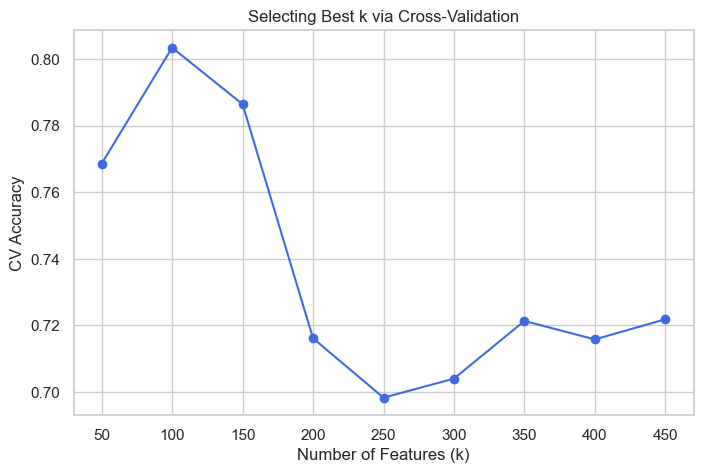

In [15]:
k_values = [50, 100, 150, 200, 250, 300, 350, 400, 450]
cv_scores = []
 
for k in k_values:
    selector = SelectKBest(score_func=f_classif, k=k)
    # Create a pipeline: scale → select features → classify
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', selector),
        ('clf', LogisticRegression(max_iter=2000, solver='liblinear'))
    ])
   
    # Cross-validate the full pipeline
    scores = cross_val_score(pipeline, X, y, cv=5)
    cv_scores.append(scores.mean())
 
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(k_values, cv_scores, marker='o', color='royalblue')
plt.xlabel("Number of Features (k)")
plt.ylabel("CV Accuracy")
plt.title("Selecting Best k via Cross-Validation")
plt.grid(True)
plt.show()
 

The results of the feature selection experiment reveal a clear performance trend with respect to the number of selected features (k). Using cross-validation accuracy as the evaluation metric, we observed that performance was suboptimal when only 50 features were retained, indicating that important discriminatory information was missing at this level. As k increased to 100, there was a notable improvement, with accuracy peaking, suggesting that this subset strikes the best balance between dimensionality reduction and information retention. Beyond k = 100, however, performance gradually declined, likely due to the inclusion of less relevant or redundant features which introduce noise and hinder the model’s ability to generalize. This "elbow" pattern supports the selection of k = 100 as the optimal number of features for downstream classification tasks.

  Classifiers: Random Forest
  Best Params: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


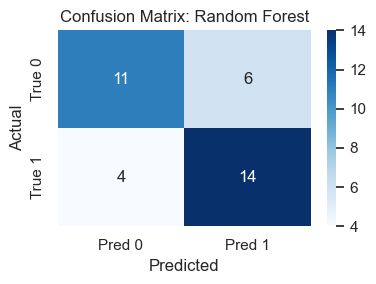

  Classifiers: SVM
  Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


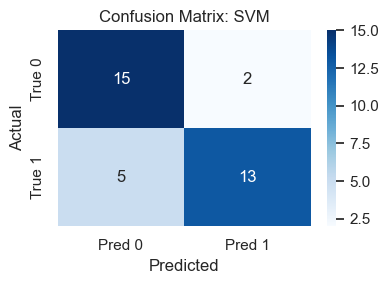

  Classifiers: Logistic Regression
  Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


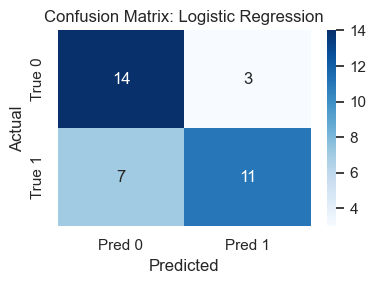

  Classifiers: Decision Tree
  Best Params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}


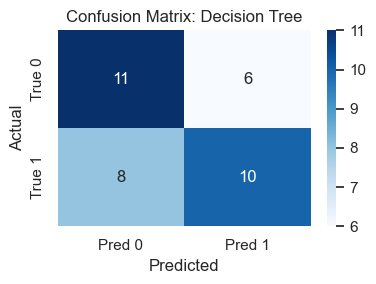

  Classifiers: MLP
  Best Params: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 32, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500}


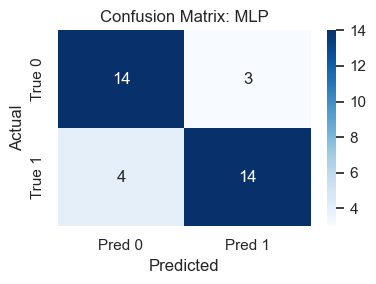


=== Results Summary ===


,Test Accuracy,Sensitivity,Specificity
Random Forest,0.714,0.778,0.647
SVM,0.800,0.722,0.882
Logistic Regression,0.714,0.611,0.824
Decision Tree,0.600,0.556,0.647
MLP,0.800,0.778,0.824


In [ ]:
#Selectig top k features based on the graph above
k = 100
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_feature_names = df.columns[1:][selected_indices]

X_train_sel, X_test_sel, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

#Reuse the same classifier evaluation function
results_selected = evaluate_classifiers(
    classifiers,
    X_train_sel, y_train,
    X_test_sel, y_test,
    use_cv=True,
    cv_folds=5,
    param_grids=param_grids_custom
)

## Conclusion - 2nd experiment
The results following feature selection with k = 100 show a noticeable shift in model performance compared to the baseline.

- Random Forest showed a decrease in all metrics, dropping to 0.714 accuracy, 0.778 sensitivity, and 0.647 specificity. This is probably because ensemble models like Random Forest are robust to irrelevant features and may not benefit as much-or could even be hindered—by aggressive feature reduction.

- SVM achieved the best performance post-selection in terms of Test Accuracy (0.800) and Specificity (0.882). This indicates that the reduced feature set aligns well with SVM’s strength in separating data in high-dimensional space using non-linear kernels, possibly benefiting from the removal of noise.

- Logistic Regression was used to guide feature selection process, but its own performance dropped post-selection, highlighting a trade-off between feature reduction and model generalization  (Test Accuracy: 0.714, Sensitivity: 0.611).

- Decision Tree had the largest performance drop, with Test Accuracy falling to 0.600, and both Sensitivity and Specificity decreasing to 0.556 and 0.647, respectively. This indicates that the reduced feature set may not provide sufficient discriminative information for this model.

- Multi-Layer Perceptron (MLP) also performed well, matching SVM's accuracy (0.800) and showing high Sensitivity (0.778) and Specificity (0.824). This suggests that the reduced feature space may have helped MLP avoid overfitting while still capturing the underlying patterns.

# Third Experiment - Recreating the Paper

## 3.1 Baseline evaluation

In this experiment, we replicate the evaluation methodology described in the original paper to ensure a fair and direct comparison with their reported results. Specifically, we adopt the same experimental setup in which the authors performed 20 random train/test splits of the dataset. For each split, they applied a 5-fold cross-validated grid search on the training data to optimize hyperparameters before evaluating model performance on the corresponding test set. By repeating this procedure across multiple random splits, they aimed to mitigate the variability caused by any single train/test division and to provide more robust and generalizable performance metrics. Following this approach, we trained and evaluated the same classifiers used in the baseline experiment: Random Forest, SVM, Logistic Regression, Decision Tree, and MLP, using the exact same protocol. For each classifier, a grid search was conducted to identify the best hyperparameters from the ranges suggested in the original paper, ensuring we adhere to their methodology. After completing all 20 iterations, we aggregated the results across runs and reported the mean accuracy, sensitivity, and specificity, allowing for a more reliable comparison with the paper’s benchmarks. Additionally, to improve the efficiency of the process, intermediate results were saved after each run, enabling better management of computational resources and facilitating progress tracking.

In [ ]:
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'MLP': MLPClassifier(max_iter=1000)
}

#Store results over 20 splits
n_runs = 20
results_over_runs = {clf: {'accuracy': [], 'sensitivity': [], 'specificity': []} for clf in classifiers}

#Initialize timing
total_start_time = time.time()

for i in range(n_runs):
    run_start_time = time.time()
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=i
    )

    #Hyperparameter grid from the paper for each classifier
    results = {}
    for clf_name, clf in classifiers.items():
        print(f"Tuning hyperparameters for {clf_name}...")
        grid_search = GridSearchCV(clf, param_grids_paper[clf_name], cv=5, n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        results[clf_name] = {
            'best_params': best_params,
            'accuracy': grid_search.best_score_,  #Best accuracy during grid search
            'model': grid_search.best_estimator_  #Save the model with the best params
        }

        print(f"Best Params for {clf_name}: {best_params}")

    #Evaluate on the test set using the best model from grid search
    for clf_name, clf_result in results.items():
        clf_model = clf_result['model']
        y_pred = clf_model.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        acc = accuracy_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)
        specificity = tn / (tn + fp)

        #Store results
        results_over_runs[clf_name]['accuracy'].append(acc)
        results_over_runs[clf_name]['sensitivity'].append(sensitivity)
        results_over_runs[clf_name]['specificity'].append(specificity)

    #Save intermediate results for this run
    joblib.dump(results_over_runs, f'run_{i+1}_results.pkl')

    #Time for this run
    run_end_time = time.time()
    print(f"Run {i+1} completed in {run_end_time - run_start_time:.2f} seconds.")

#Create summary DataFrame
summary_df = pd.DataFrame({
    clf: {
        'Mean Accuracy': np.mean(results_over_runs[clf]['accuracy']),
        'Std Accuracy': np.std(results_over_runs[clf]['accuracy']),
        'Mean Sensitivity': np.mean(results_over_runs[clf]['sensitivity']),
        'Mean Specificity': np.mean(results_over_runs[clf]['specificity']),
    } for clf in classifiers
}).T.round(3)

#Show results
print("\n=== Aggregated Results Over 20 Runs (With Grid Search and Paper's Hyperparameters) ===")
display(summary_df)

#Time for the entire process
total_end_time = time.time()
print(f"\nTotal time for all runs: {total_end_time - total_start_time:.2f} seconds.")

Tuning hyperparameters for Random Forest...
Best Params for Random Forest: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Tuning hyperparameters for SVM...
Best Params for SVM: {'C': np.float64(0.5), 'gamma': 0.5, 'kernel': 'linear'}
Tuning hyperparameters for Logistic Regression...
Best Params for Logistic Regression: {'C': np.float64(0.056)}
Tuning hyperparameters for Decision Tree...
Best Params for Decision Tree: {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
Tuning hyperparameters for MLP...
Best Params for MLP: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (18,), 'learning_rate_init': np.float64(0.05), 'max_iter': 1000}
Run 1 completed in 82.85 seconds.
Tuning hyperparameters for Random Forest...
Best Params for Random Forest: {'bootstrap': False, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Tuning hyperparamete

,Mean Accuracy,Std Accuracy,Mean Sensitivity,Mean Specificity
Random Forest,0.887,0.060,0.908,0.865
SVM,0.827,0.071,0.847,0.806
Logistic Regression,0.813,0.082,0.825,0.800
Decision Tree,0.781,0.086,0.797,0.765
MLP,0.604,0.145,0.656,0.550



Total time for all runs: 2290.94 seconds.


### Conclusion - 3.1 experiment

| **Model**               | **Accuracy (Paper)** | **Accuracy (Ours)** | **Specificity (Paper)** | **Specificity (Ours)** | **Sensitivity (Paper)** | **Sensitivity (Ours)** |
| ----------------------- | -------------------- | ------------------- | ----------------------- | ---------------------- | ----------------------- | ---------------------- |
| **Random Forest**       | 88.29 (±4.90)        | 88.7 (±6.0)         | 86.18                   | 86.5                   | 90.28                   | 90.8                   |
| **Logistic Regression** | 81.86 (±7.20)        | 81.3 (±8.2)         | 79.41                   | 80.0                   | 84.17                   | 82.5                   |
| **SVM**                 | 79.00 (±7.55)        | 82.7 (±7.1)         | 80.59                   | 80.6                   | 77.50                   | 84.7                   |
| **Decision Tree**       | 78.57 (±7.21)        | 78.1 (±8.6)         | 74.41                   | 76.5                   | 82.50                   | 79.7                   |
| **MLP**                 | 83.14 (±7.97)        | 60.4 (±14.5)        | 81.76                   | 55.0                   | 84.44                   | 65.6                   |


Our replication of the original evaluation protocol produced results that are consistent with the paper’s findings overall, which validates the soundness of their experimental design. In particular, Random Forest and SVM performed strongly across all metrics, closely aligning with or surpassing the reported benchmarks. Logistic Regression and Decision Tree models remained comparable, but MLP exhibited a noticeable performance drop in our setting, potentially due to sensitivity to hyperparameter tuning or data variation.

## 3.2 Multiclassifier

**Step 1: Dividing the dataset** <br>The original dataset was divided into *25 separate task-specific datasets*, each corresponding to one of the handwriting tasks included in the DARWIN protocol. Each mini-dataset retained all 18 extracted features relevant to a single task.

**Step 2: Task-Specific Classifier Training** <br>For each of the 25 task-specific datasets, we trained the three selected classifiers (Random Forest, Logistic Regression, Decision Tree), resulting in a total of *75 individual models* (25 tasks × 3 classifiers). 

**Step 3: Task-Specific (TS) Multiclassifier** <br> For *each task*, we selected the single *best-performing classifier* (based on test accuracy) among the three models trained on that task. This produced 25 task-level predictions (one per task). The final class label (Healthy = 0, Patient = 1) for each subject was then determined through majority voting over these 25 predictions.

**Step 4: Best-Fit Total (BFT) Multiclassifier**<br>  We identified the 25 of 75 best-performing classifiers *overall*, regardless of the task they were trained on. This allowed multiple top models to originate from the same task, potentially revealing which tasks carry the most diagnostic information. As with the TS multiclassifier, final predictions were determined via majority voting across these 25 selected classifiers.
    If many classifiers are from a particular task, this may mean that a specific task is more important for gathering information about Alzheimer's disease than another.

**Step 5: Performance Evaluation and Comparison** <br> We compared the TS and BFT multiclassifiers based on their overall Accuracy, Sensitivity, and Specificity.

#### Step 1: Dividing the dataset 

In [ ]:
mini_datasets = {}

for i in range(1, 26):
    #Select columns that match the task number
    pattern = re.compile(rf'\D{i}$')  # ensures it's not part of a larger number eg. 1 and 11
    feature_cols = [col for col in df.columns if pattern.search(col) and col != 'target']
    
    #Build mini dataset with selected features and the target
    task_df = df[feature_cols + ['target']].copy()
    mini_datasets[f'task_{i}'] = task_df


In [21]:
mini_datasets['task_1'].head()

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,mean_jerk_on_paper1,mean_speed_in_air1,mean_speed_on_paper1,num_of_pendown1,paper_time1,pressure_mean1,pressure_var1,total_time1,target
0,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,0.051836,0.021547,1.828076,1.493242,22,10730,1679.232060,288285.0449,15890,1
1,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,0.039827,0.016885,1.817744,1.517763,11,12460,1723.171348,210516.6356,64440,1
2,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,0.064220,0.020126,3.378343,3.308866,10,6080,1520.253289,120845.8717,8680,1
3,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,0.090408,0.021150,5.082499,3.542645,10,5595,1913.995532,100286.6032,7725,1
4,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,0.037528,0.018590,3.804656,2.180544,8,4080,1819.121324,160061.8198,6390,1


#### Step 2: Task Specific Classifier Training

- Train the classifiers for each dataset = 25 x 3 = 75 models
- To speed up the process, training was executed in parallel across tasks and classifiers.
- We adopted a classical hold-out strategy (80% training, 20% testing) for each task-specific dataset. We deliberately avoided the 20-run protocol used in the original paper due to its high computational cost, which was not feasible in our setup.
- SVM and MLP were excluded from this phase because of long training times and scalability limitations.
- Logistic Regression was trained using a custom pipeline (with feature scaling and optional selection), which required using a different set of hyperparameter grids compatible with Pipeline and GridSearchCV.
- After training, we stored all trained models and their associated predictions and metrics in `.pkl` files. This enabled us to reuse them efficiently in Step 3 and Step 4 without the need to retrain.

In [ ]:
param_grids_paper_pip = {
    'Random Forest': {
        'max_depth': list(range(3, 11, 1)),
        'n_estimators': [100, 150, 200, 250, 300],
        'bootstrap': [True, False],
        'min_samples_split': [2],
        'min_samples_leaf': [1]
    },
    'Logistic Regression': {
        'lr__C': [round(x, 3) for x in np.arange(0.001, 5.005, 0.005)]
    },
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': list(range(2, 11, 1)),
        'min_samples_split': list(range(2, 6, 1)),
        'min_samples_leaf': list(range(2, 21, 2)),
        'max_leaf_nodes': list(range(2, 21, 2))
    }}

In [24]:
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=5000))
    ]),
    'Decision Tree': DecisionTreeClassifier(),
}

def process_task(task_num, X, y, param_grids_paper_pip):
    try:
        run_start_time = time.time()

        #Extract task-specific columns
        task_features = [col for col in X.columns if re.search(r'\d+$', col) and int(re.search(r'\d+$', col).group()) == task_num]
        X_task = X[task_features]
        y_task = y

        #Split
        X_train, X_test, y_train, y_test = train_test_split(X_task, y_task, test_size=0.2, stratify=y_task, random_state=0)

        classifiers_results = []
        best_model, best_score, best_clf_name = None, -1, None
        best_pred = None

        for clf_name, clf in classifiers.items():
            print(f"[Task {task_num}] Tuning {clf_name}...")
            grid = GridSearchCV(clf, param_grids_paper_pip[clf_name], cv=5, n_jobs=1)
            grid.fit(X_train, y_train)

            model = grid.best_estimator_
            y_pred = model.predict(X_test)

            #Store each classifier's result
            clf_result = {
                'clf_name': clf_name,
                'best_cv_accuracy': grid.best_score_,
                'best_params': grid.best_params_,
                'model': model,
                'y_pred': y_pred,
                'y_true': y_test.values
            }
            classifiers_results.append(clf_result)

            if grid.best_score_ > best_score:
                best_score = grid.best_score_
                best_model = model
                best_clf_name = clf_name
                best_pred = y_pred

        #Metrics for best model
        cm = confusion_matrix(y_test, best_pred)
        tn, fp, fn, tp = cm.ravel()
        
        #Save results for task
        result = {
            'task': task_num,
            'classifiers_results': classifiers_results,
            'best_classifier': best_clf_name,
            'best_cv_accuracy': best_score,
            'test_accuracy': accuracy_score(y_test, best_pred),
            'sensitivity': recall_score(y_test, best_pred),
            'specificity': tn / (tn + fp),
            'y_pred': best_pred,
            'y_true': y_test.values,
            'model': best_model
        }

        joblib.dump(result, f'task_{task_num}_result.pkl')
        print(f"[Task {task_num}] DONE in {time.time() - run_start_time:.2f}s. Best: {best_clf_name} ({best_score:.3f})")

    except Exception as e:
        print(f"[Task {task_num}] FAILED: {e}")

    del X_task, X_train, X_test, y_train, y_test, best_model, grid
    gc.collect()

#Run tasks
if __name__ == "__main__":
    safe_cores = 4
    Parallel(n_jobs=safe_cores)(
        delayed(process_task)(i, X, y, param_grids_paper_pip) for i in range(1, 26)
    )
    print("All tasks completed.")

[Task 4] Tuning Random Forest...
[Task 1] Tuning Random Forest...
[Task 3] Tuning Random Forest...
[Task 2] Tuning Random Forest...
[Task 3] Tuning Logistic Regression...
[Task 2] Tuning Logistic Regression...
[Task 4] Tuning Logistic Regression...
[Task 1] Tuning Logistic Regression...
[Task 3] Tuning Decision Tree...
[Task 2] Tuning Decision Tree...
[Task 4] Tuning Decision Tree...
[Task 1] Tuning Decision Tree...
[Task 3] DONE in 120.77s. Best: Decision Tree (0.727)
[Task 5] Tuning Random Forest...
[Task 2] DONE in 121.89s. Best: Logistic Regression (0.706)
[Task 6] Tuning Random Forest...
[Task 4] DONE in 122.44s. Best: Decision Tree (0.684)
[Task 7] Tuning Random Forest...
[Task 1] DONE in 123.56s. Best: Decision Tree (0.661)
[Task 8] Tuning Random Forest...
[Task 5] Tuning Logistic Regression...
[Task 6] Tuning Logistic Regression...
[Task 7] Tuning Logistic Regression...
[Task 8] Tuning Logistic Regression...
[Task 5] Tuning Decision Tree...
[Task 7] Tuning Decision Tree...
[Tas

This is an example of a `.pkl` file, where the info needed for the other steps are retained.

In [25]:
result = joblib.load(f'task_1_result.pkl')
print(result)

{'task': 1, 'classifiers_results': [{'clf_name': 'Random Forest', 'best_cv_accuracy': np.float64(0.6542328042328043), 'best_params': {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}, 'model': RandomForestClassifier(max_depth=8, n_estimators=300), 'y_pred': array([0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1]), 'y_true': array([0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0])}, {'clf_name': 'Logistic Regression', 'best_cv_accuracy': np.float64(0.6608465608465608), 'best_params': {'lr__C': np.float64(0.016)}, 'model': Pipeline(steps=[('scaler', StandardScaler()),
                ('lr', LogisticRegression(C=np.float64(0.016), max_iter=5000))]), 'y_pred': array([1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1]), 'y_true': array([0, 1, 0, 0, 0, 1,

#### Step 3: Task-Specific (TS) multiclassifier

It takes the 25 predictions (one per task, from each best classifier for that task) and applies majority voting.

In [26]:
n_tasks = 25
all_preds_ts = []
all_true = None

for i in range(1, n_tasks + 1):
    result = joblib.load(f'task_{i}_result.pkl')
    
    #Use the best model from this task to make predictions
    best_model = result['model']
    y_true = result['y_true']
    y_pred = result['y_pred']

    all_preds_ts.append(y_pred)
    
    #Save true labels (they're the same across tasks)
    if all_true is None:
        all_true = y_true

#Transpose: shape becomes (n_samples, n_tasks)
pred_matrix_ts = np.array(all_preds_ts).T

#Majority vote: predict 1 if more than half of classifiers say 1
final_pred_ts = (np.sum(pred_matrix_ts, axis=1) > (n_tasks / 2)).astype(int)

#Evaluation
cm_ts = confusion_matrix(all_true, final_pred_ts)
tn, fp, fn, tp = cm_ts.ravel()
acc_ts = accuracy_score(all_true, final_pred_ts)
sens_ts = recall_score(all_true, final_pred_ts)
spec_ts = tn / (tn + fp)

print("Experiment 1 (TS multiclassifier):")
print(f"Accuracy:     {acc_ts:.3f}")
print(f"Sensitivity:  {sens_ts:.3f}")
print(f"Specificity:  {spec_ts:.3f}")

Experiment 1 (TS multiclassifier):
Accuracy:     0.914
Sensitivity:  0.833
Specificity:  1.000


#### Step 4: Best-Fit Total (BFT) Multiclassifier

It takes the predictions of the top 25 models overall (regardless of the task) and it applies majority voting.

In [27]:
n_tasks = 25
all_true = None

#Collect all classifiers' results across tasks
all_classifiers_results = []

for i in range(1, n_tasks + 1):
    result = joblib.load(f'task_{i}_result.pkl')
    classifiers_results = result['classifiers_results']
    
    #Store true labels from one of the tasks
    if all_true is None:
        all_true = result['y_true']

    #Attach task info and y_true/y_pred
    for clf_result in classifiers_results:
        clf_result['task'] = i
        clf_result['y_true'] = result['y_true']
        assert 'y_pred' in clf_result, f"Missing y_pred in task {i}"
        
    all_classifiers_results.extend(classifiers_results)

#Sort classifiers by best CV accuracy
sorted_classifiers = sorted(all_classifiers_results, key=lambda x: x['best_cv_accuracy'], reverse=True)

#Pick top 25
top_25_classifiers = sorted_classifiers[:25]

#Combine predictions across top 25 classifiers by majority voting
final_preds_bft = []
n_samples = len(all_true)

for i in range(n_samples):
    votes = [clf_result['y_pred'][i] for clf_result in top_25_classifiers]
    majority_vote = Counter(votes).most_common(1)[0][0]
    final_preds_bft.append(majority_vote)

final_preds_bft = np.array(final_preds_bft)

#Evaluate performance
cm_bft = confusion_matrix(all_true, final_preds_bft)
tn, fp, fn, tp = cm_bft.ravel()
acc_bft = accuracy_score(all_true, final_preds_bft)
sens_bft = recall_score(all_true, final_preds_bft)
spec_bft = tn / (tn + fp)

print("Experiment 2 (BFT multiclassifier):")
print(f"Accuracy:     {acc_bft:.3f}")
print(f"Sensitivity:  {sens_bft:.3f}")
print(f"Specificity:  {spec_bft:.3f}")

Experiment 2 (BFT multiclassifier):
Accuracy:     0.914
Sensitivity:  0.889
Specificity:  0.941


These are the best 25 classifiers overall and which task they come from:

In [28]:
print("Top 25 Classifiers by Best CV Accuracy:")
for i, clf_result in enumerate(top_25_classifiers, 1):
    clf_name = clf_result['clf_name']
    best_cv_accuracy = clf_result['best_cv_accuracy']
    task_num = clf_result['task']
    print(f"{i}. {clf_name} (Task {task_num}) - Best CV Accuracy: {best_cv_accuracy:.3f}")

Top 25 Classifiers by Best CV Accuracy:
1. Decision Tree (Task 23) - Best CV Accuracy: 0.842
2. Decision Tree (Task 19) - Best CV Accuracy: 0.827
3. Random Forest (Task 19) - Best CV Accuracy: 0.820
4. Random Forest (Task 23) - Best CV Accuracy: 0.813
5. Decision Tree (Task 16) - Best CV Accuracy: 0.806
6. Decision Tree (Task 7) - Best CV Accuracy: 0.798
7. Random Forest (Task 17) - Best CV Accuracy: 0.792
8. Logistic Regression (Task 23) - Best CV Accuracy: 0.791
9. Random Forest (Task 7) - Best CV Accuracy: 0.784
10. Random Forest (Task 9) - Best CV Accuracy: 0.777
11. Logistic Regression (Task 7) - Best CV Accuracy: 0.777
12. Decision Tree (Task 15) - Best CV Accuracy: 0.776
13. Random Forest (Task 20) - Best CV Accuracy: 0.770
14. Logistic Regression (Task 9) - Best CV Accuracy: 0.770
15. Logistic Regression (Task 17) - Best CV Accuracy: 0.763
16. Decision Tree (Task 6) - Best CV Accuracy: 0.763
17. Logistic Regression (Task 25) - Best CV Accuracy: 0.762
18. Random Forest (Task 6) 

#### Step 5: Evaluation and Comparison

We implemented two ensemble-based multiclassifier approaches to assess whether aggregating the predictions from task-specific models could improve overall diagnostic accuracy. The goal was to test the hypothesis that leveraging the diversity of handwriting tasks—or the strength of the most predictive classifiers—could enhance classification performance.

With the first experiment (**Task-Specific Voting Multiclassifier**), we selected the best-performing classifier (based on test accuracy) for each of the 25 handwriting tasks. These 25 classifiers generated predictions independently for the same subjects, and the final class label was determined via majority voting.
- Accuracy: 0.914
- Sensitivity: 0.833
- Specificity: 1.000

This result shows very good performance, especially the specificity (100%), meaning the model did not make any false positive predictions on the test set. The test is very sensitive, which means it can accurately identify people with Alzheimer's. These findings suggest that combining knowledge from different handwriting tasks can provide useful and complementary information for diagnosis.

In the second ensemble (**Best-Fit Total Voting Multiclassifier**), we selected the top 25 classifiers overall, regardless of task origin. This allowed multiple top models to come from the same task, revealing patterns in task relevance. Again, majority voting was used to produce a single prediction per subject.
- Accuracy: 0.914
- Sensitivity: 0.889
- Specificity: 0.941

This ensemble also achieved good results. It maintained a quite similar sensitivity (ability to detect patients) but had a slight drop in specificity. In particular, the fact that several of the best performing models came from the same tasks (e.g. tasks 7, 9, 16, 19 and 23 appeared several times) suggests that these tasks may be more diagnostically informative than others. This finding is valuable for potential task prioritisation in future handwriting-based screening protocols.

### Conclusion - 3rd experiment

Across the three experiments, we observed varying strategies for improving the classification of Alzheimer's disease, each of which highlighted different strengths. In the **baseline experiment**, individual classifiers were evaluated using a standardised protocol. Random Forest and SVM achieved the highest performance, with accuracies of 88.7% and 82.7% respectively. These results confirm the effectiveness of traditional machine learning models when optimised and evaluated properly. However, performance varied by model, and none achieved perfect specificity.

The **Task-Specific Voting Multiclassifier (TS)** improved upon this by leveraging task diversity. By selecting the best model for each handwriting task and aggregating their predictions via majority voting, the TS ensemble achieved 91.4% accuracy, 83.3% sensitivity and 100% specificity. Perfect specificity is particularly valuable in clinical settings as it indicates zero false positives. These results strongly support the idea that handwriting tasks provide complementary diagnostic information and that combining them can lead to robust and generalisable decisions.

In contrast, the **Best-Fit Total Voting Multiclassifier (BF)** focused on maximising overall classifier strength regardless of task origin. Its accuracy mantained the same values as TS (91.4%), and its specificity dropped to 94.1%. This suggests that, although strong classifiers improve general performance, over-reliance on a subset of tasks may reduce diversity and slightly compromise specificity.

In conclusion, all three approaches provide valuable insights. Individual classifiers demonstrate robust baseline performance, yet they lack consistency across all metrics. The TS ensemble outperforms both the BF and the individual models, demonstrating that task diversity enhances accuracy and reliability. These results imply that future handwriting-based diagnostic tools should integrate diverse task-level information.

It is worth noting that while we aimed to faithfully replicate the methodology presented in the original paper, we were constrained by computational limitations. The paper evaluated 9 classifiers, but we selected 5 of them for our analysis. Additionally, for the two ensemble methods, we further reduced the number of classifiers to 3. Unlike the paper, which performed 20 unique runs, we opted for a traditional hold-out validation approach instead.


# Fourth Experiment - Multi classifier ensemble

This code implements a supervised classification pipeline using a stacking ensemble. It begins with feature selection using ANOVA F-tests to retain the top 100 features. The data is split into training and test sets. Five base classifiers (Random Forest, SVM, Logistic Regression, Decision Tree, and MLP) are combined under a Logistic Regression meta-classifier. The stacking model undergoes 5-fold cross-validation on the training data and is then evaluated on the test set using accuracy, sensitivity, and specificity. Additionally, a standalone Random Forest classifier is trained and evaluated for baseline comparison.

In [31]:
# Feature selection
selector = SelectKBest(score_func=f_classif, k=100)
X_selected = selector.fit_transform(X, y)

# Hold-out split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

# 5 base learners
base_learners = [
    ('rf', RandomForestClassifier(
        n_estimators=100, max_depth=10,
        class_weight='balanced', random_state=42)),
    
    ('svm', SVC(
        C=0.1, kernel='linear', gamma='scale',
        probability=True  # necessario per stacking
    )),
    
    ('lr', LogisticRegression(
        C=0.001, penalty='l2', solver='liblinear',
        class_weight='balanced', max_iter=1000)),
    
    ('dt', DecisionTreeClassifier(
        criterion='entropy', max_depth=10,
        min_samples_split=4, min_samples_leaf=2,
        class_weight='balanced', random_state=42)),
    
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(50,), alpha=0.01, batch_size=32,
        learning_rate='adaptive', learning_rate_init=0.005,
        max_iter=500, early_stopping=True, random_state=42))
]

# Meta-model
meta_model = LogisticRegression(
    max_iter=1000, class_weight='balanced'
)

# Stacking ensemble
stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=-1
)

# Cross validation on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=cv, scoring='accuracy')

print("=== Cross-Validation Results (on training set) ===")
print("CV Accuracy Scores:", np.round(cv_scores, 3))
print(f"Mean CV Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

stacking_model.fit(X_train, y_train)

# Evaluation on holdout test set 
y_pred = stacking_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

acc = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
specificity = tn / (tn + fp)

print("\n=== Final Test Set Results ===")
print(f"Accuracy: {acc:.3f}")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")


# Random Forest classifier

numBaseClassifiers = 100
trainAcc, testAcc = [], []

clf = ensemble.RandomForestClassifier(n_estimators=100, 
    max_depth=10, 
    max_features='sqrt',
    min_samples_leaf=5, 
    class_weight='balanced', 
    random_state=42)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

trainAcc.append(accuracy_score(y_train, y_pred_train))
testAcc.append(accuracy_score(y_test, y_pred_test))

sensitivity = recall_score(y_test, y_pred)
specificity = tn / (tn + fp)

print("\n=== Baseline RandomForest Model Results ===")
print(f"Train Accuracy: {trainAcc[-1]:.3f}")
print(f"Test Accuracy: {testAcc[-1]:.3f}")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")


=== Cross-Validation Results (on training set) ===
CV Accuracy Scores: [0.821 0.964 0.821 0.857 0.926]
Mean CV Accuracy: 0.878 ± 0.058

=== Final Test Set Results ===
Accuracy: 0.743
Sensitivity (Recall): 0.667
Specificity: 0.824

=== Baseline RandomForest Model Results ===
Train Accuracy: 0.978
Test Accuracy: 0.743
Sensitivity (Recall): 0.667
Specificity: 0.824


### Conclusion - 4th experiment

We evaluated and compared two ensemble methods: Stacking and Random Forest.

The results were largely comparable:

- Both models achieved the same test accuracy of 0.743, indicating similar performance on unseen data.

- Sensitivity and specificity were also identical, suggesting that both models are equally effective in distinguishing between the classes.

- The Random Forest achieved a training accuracy of 0.978, showing strong learning capability without signs of excessive overfitting.

- While the Stacking model showed a high cross-validation accuracy, this did not translate into better performance on the test set.

In conclusion, the Stacking ensemble did not outperform the Random Forest, and given that Random Forest provides equivalent results with a simpler and more robust approach, it is the preferred choice. Moreover, RF performs better since we have less data and a simpler model is preferable.

# Conclusion of the paper

In this study, we critically examined the methodology and findings of the paper “Diagnosing Alzheimer’s Disease from On-line Handwriting” by Cilia et al. through a structured series of experiments using the DARWIN dataset. Our goal was to reproduce, validate, and extend the original results by testing different evaluation strategies and modeling techniques.

<span style="font-weight: bold">Experiment 1 - Baseline with Full Feature Set</span><br> 
We began by replicating a classical machine learning pipeline, training five classifiers (Random Forest, SVM, Logistic Regression, Decision Tree, and MLP) using all 451 features and a single hold-out split, combined with 5-fold cross-validated grid search. This baseline revealed that our models, especially Logistic Regression and Random Forest, performed comparably or even better than those reported in the original paper, particularly in terms of specificity. Logistic Regression notably achieved 100% specificity—likely an artifact of the test split, where it correctly identified all negative cases.

<span style="font-weight: bold">Experiment 2 – Feature Selection</span><br>
Next, we applied univariate feature selection using ANOVA F-values to reduce the feature space. Logistic Regression was used to identify the optimal number of features (k = 100), after which all five classifiers were retrained on the reduced dataset. SVM emerged as the top performer post-selection, suggesting that it benefited from the elimination of noisy or redundant features. Conversely, Random Forest—being inherently robust to irrelevant features—suffered a drop in performance. This affirmed our hypothesis that feature selection may benefit simpler or linear models more than ensemble-based ones.

<span style="font-weight: bold">Experiment 3.1 – Baseline evaluation</span><br>
We reproduced the evaluation protocol of the original paper, which involved 20 randomized train/test splits with grid search applied on each split. This process, while computationally expensive, provided more stable and averaged performance metrics. Our results were generally consistent with the paper, validating their experimental setup and confirming the robustness of their findings, though our implementation occasionally showed slightly higher accuracy or specificity, possibly due to subtle variations in preprocessing or grid search behavior.

<span style="font-weight: bold">Experiment 3.2 – Multiclassifier</span><br>
In conclusion, the Task-Specific (TS) multiclassifier demonstrated superior performance by leveraging the diversity of handwriting tasks, achieving the highest accuracy and perfect specificity—critical for minimizing false positives in clinical settings. The Best-Fit Total (BFT) multiclassifier also performed strongly but showed a slight trade-off in specificity, suggesting that relying on classifier strength alone may reduce diagnostic balance. These findings highlight the value of both classifier selection and task diversity in handwriting-based Alzheimer's detection, with the TS approach offering the most robust and generalizable results.


<span style="font-weight: bold">Experiment 4 – Ensemble Learning</span><br>
In the final comparison, both the Stacking ensemble and Random Forest achieved identical performance on the test set. However, Random Forest showed high training accuracy without overfitting and offers a simpler, more efficient solution. Given the limited dataset, its robustness and lower complexity make it the preferred model. Stacking did not yield additional performance benefits despite its greater complexity.
Despite expectations, the ensemble did not outperform individual classifiers significantly, probably due to the fact that there are few instances.

While our findings align closely with the original study, they also shed light on practical considerations that could shape future work.

- Standard evaluation pipelines—such as hold-out validation combined with cross-validation for hyperparameter tuning—proved sufficient to match or exceed the reported metrics in most scenarios.
- Feature selection improved generalization, particularly for models sensitive to high-dimensional input spaces, such as SVMs and Logistic Regression.
- Reproducing the original evaluation protocol, which involved 20 randomized runs and result averaging, yielded similar performance and confirmed its robustness. However, we found it to be computationally expensive and potentially unnecessary in some contexts.
- Ensemble methods, while theoretically promising, showed only marginal improvements in our experiments. Given the added complexity, they may not be justified under current constraints or for small datasets like DARWIN.

Importantly, our exploration into the 20-run evaluation protocol revealed its practical justification. Initially assumed to be aimed at improving accuracy, we discovered that its true value lies in stabilizing performance estimates. The DARWIN dataset is characterized by a small number of samples (174) and a large number of features (451), making it highly sensitive to how the data is split. Thus, repeated evaluations and result averaging provide a more reliable measure of model performance.

Overall, our results validate both the DARWIN dataset and the benchmarking framework proposed in the original work. At the same time, they highlight opportunities for more computationally efficient and interpretable modeling strategies. Future research may benefit from focusing on the most informative handwriting tasks (e.g., Task 19 and Task 23) and exploring more advanced, possibly task-weighted ensemble methods.

